In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyBigWig
from pyBioInfo.IO.File import BedFile

# Tracks of circRNA and seCLIP-seq (Figure 4e)

In [11]:
with BedFile("../../1_circRNAseq/results/circ_rna_merged.bed.gz") as f:
    circrnas = {r.name: r for r in f}

In [4]:
with BedFile("/home/zgchen/species/homo_sapiens/GRCh38.p13/gencode.v39.transcripts.bed.gz") as f:
    transcripts = {t.name: t for t in f}

In [12]:
def get_peaks(chrom, start, end):
    with BedFile("../../2_seCLIPseq/results/20241028_293T_HNRNPK_CLIP.bed.gz") as f:
        return [peak for peak in f.fetch(chrom, start, end)]

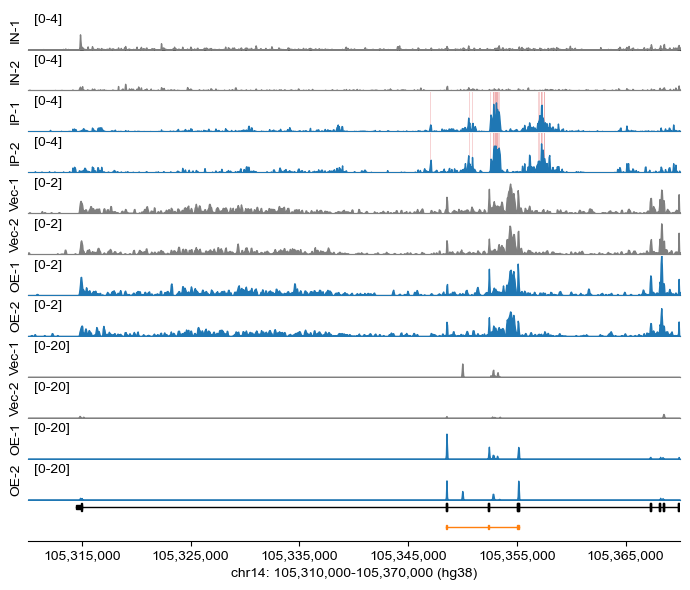

In [14]:
def smooth(xs, ys, step):
    assert len(xs) == len(ys) and len(xs) % step == 0
    xs1, ys1 = [], []
    for i in range(0, len(xs), step):
        xs1.append(np.mean(xs[i:i+step]))
        ys1.append(np.mean(ys[i:i+step]))
    return np.array(xs1), np.array(ys1)
    
tracks = [
    ["../../2_seCLIPseq/results/3_tracks/1_bw/20241028_293T_HNRNPK_CLIP_Input_Rep1_norm_both.bw", "IN-1", "C7", 4],
    ["../../2_seCLIPseq/results/3_tracks/1_bw/20241028_293T_HNRNPK_CLIP_Input_Rep2_norm_both.bw", "IN-2", "C7", 4],
    ["../../2_seCLIPseq/results/3_tracks/1_bw/20241028_293T_HNRNPK_CLIP_IP_Rep1_norm_both.bw", "IP-1", "C0", 4],
    ["../../2_seCLIPseq/results/3_tracks/1_bw/20241028_293T_HNRNPK_CLIP_IP_Rep2_norm_both.bw", "IP-2", "C0", 4],
    ["../../1_circRNAseq/results/5_tracks/1_bw_rna_seq/20210720_circRNAseq_oeNC_Rep1_norm_neg.bw", "Vec-1", "C7", 2],
    ["../../1_circRNAseq/results/5_tracks/1_bw_rna_seq/20210720_circRNAseq_oeNC_Rep2_norm_neg.bw", "Vec-2", "C7", 2],
    ["../../1_circRNAseq/results/5_tracks/1_bw_rna_seq/20210720_circRNAseq_oeHNRNPK_Rep1_norm_neg.bw", "OE-1", "C0", 2],
    ["../../1_circRNAseq/results/5_tracks/1_bw_rna_seq/20210720_circRNAseq_oeHNRNPK_Rep2_norm_neg.bw", "OE-2", "C0", 2],
    ["../../1_circRNAseq/results/5_tracks/3_bw_fusion_clean/20210720_circRNAseq_oeNC_Rep1_raw_pos.bw", "Vec-1", "C7", 20],
    ["../../1_circRNAseq/results/5_tracks/3_bw_fusion_clean/20210720_circRNAseq_oeNC_Rep2_raw_pos.bw", "Vec-2", "C7", 20],
    ["../../1_circRNAseq/results/5_tracks/3_bw_fusion_clean/20210720_circRNAseq_oeHNRNPK_Rep1_raw_pos.bw", "OE-1", "C0", 20],
    ["../../1_circRNAseq/results/5_tracks/3_bw_fusion_clean/20210720_circRNAseq_oeHNRNPK_Rep2_raw_pos.bw", "OE-2", "C0", 20],
]

chrom, start, end = "chr14", 105310000, 105370000
fig, axs = plt.subplots(len(tracks) + 1, 1, figsize=(7, 6))

if True:
    peaks = get_peaks(chrom, start, end)
    
    for i, track in enumerate(tracks):
        plt.sca(axs[i])
        bwfile = track[0]
        label = track[1]
        color = track[2]
        ylim = track[3]
        with pyBigWig.open(bwfile) as f:
            ys = np.nan_to_num(f.values(chrom, start, end), 0)
        xs = np.arange(start, end)
        xs, ys = smooth(xs, ys, 50)
        plt.fill_between(xs, 0, ys, color=color, zorder=10)
        if label.startswith("IP-"):
            for peak in peaks:
                plt.axvspan(peak.start, peak.end, lw=0, color="C3", alpha=0.2, zorder=1)
        plt.xticks([])
        plt.yticks([])
        plt.ylabel(label)
        plt.xlim(start, end)
        plt.ylim(0, ylim)
        plt.text(start + (end-start)*0.01, ylim * 0.9, "[0-%d]" % ylim, va="top")
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["left"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)

if True:
    plt.sca(axs[-1])
    if True: # circRNA
        cid = "circRNA.18906"
        circ = circrnas[cid]
        y, h, color = 0.7, 0.1, "C1"
        x1, x2 = max(circ.start, start), min(circ.end, end)
        if x1 < x2:
            plt.plot([x1, x2], [y, y], lw=1, color=color)
        for x1, x2 in circ.blocks:
            x1, x2 = max(x1, start), min(x2, end)
            if x1 < x2:
                plt.bar((x1+x2)/2, h*2, bottom=y-h, width=x2-x1, edgecolor=color, color=color, lw=1)
    if True: # Isoform
        tid = "ENST00000325438.12"
        t = transcripts[tid]
        y, h, color = 1 + 0.7, 0.1, "black"
        x1, x2 = max(t.start, start), min(t.end, end)
        if x1 < x2:
            plt.plot([x1, x2], [y, y], lw=1, color=color)
        for x1, x2 in t.blocks:
            x1, x2 = max(x1, start), min(x2, end)
            if x1 < x2:
                plt.bar((x1+x2)/2, h*2, bottom=y-h, width=x2-x1, edgecolor=color, color=color, lw=1)
                if t.thick:
                    x1, x2 = max(x1, t.thick[0]), min(x2, t.thick[1])
                    if x1 < x2:
                        h = 0.2
                        plt.bar((x1+x2)/2, h*2, bottom=y-h, width=x2-x1, edgecolor=color, color=color, lw=1)
    plt.yticks([])
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xlim(start, end)
    plt.ylim(0, 2)
    xs = np.arange(start + 5000, end, 10000)
    plt.xticks(xs, [format(x, ",") for x in xs])
    plt.xlabel("%s: %s-%s (hg38)" % (chrom, format(start, ","), format(end, ",")))

plt.tight_layout(h_pad=0.1)
plt.savefig("figures/circRNA_tracks.PACS2.pdf")
plt.show()
plt.close()